In [1]:
import re
import numpy as np
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
from nltk.corpus import stopwords
import string

In [3]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
ner_dataset = load_dataset("tner/bc5cdr")
test_sentences = ner_dataset['test']['tokens']
test_tags = ner_dataset['test']['tags']
tag_to_entity = {0: 'O', 1: 'B-Chemical', 2: 'B-Disease', 3: 'I-Chemical', 4: 'I-Disease'}


def extract_entities_debug(sentences, tags, entity_type="Disease"):
    entities = []
    for sentence, tag_seq in zip(sentences, tags):
        entity = []
        for token, tag in zip(sentence, tag_seq):
            tag_label = tag_to_entity.get(tag, 'O')
            if tag_label == f"B-{entity_type}":
                if entity:
                    entities.append(" ".join(entity))
                    entity = []
                entity.append(token)
            elif tag_label == f"I-{entity_type}":
                entity.append(token)
            else:
                if entity:
                    entities.append(" ".join(entity))
                    entity = []
        if entity:
            entities.append(" ".join(entity))
    print("Extracted Entities before deduplication:", entities)
    return list(set(entities)) 
disease_entities = extract_entities_debug(test_sentences, test_tags)
print("Extracted Disease Entities:", disease_entities)
if not disease_entities:
    print("No disease entities found. Please check the tags in the dataset.")
else:
    def preprocess_entities(entities):
        filtered_entities = []
        for entity in entities:
            entity = entity.lower()  # Convert to lowercase
            entity = re.sub(r'[^a-z\s]', '', entity)  # Remove non-alphabetic characters
            words = entity.split()
            filtered_words = [word for word in words if word not in stop_words and word not in punctuation]
            if filtered_words:
                filtered_entities.append(" ".join(filtered_words))
        return filtered_entities
    disease_entities = preprocess_entities(disease_entities)
    print("Preprocessed Disease Entities:", disease_entities)
    if not disease_entities:
        raise ValueError("No valid disease entities found after preprocessing.")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased")
    def get_bert_embeddings(text_list):
        inputs = tokenizer(text_list, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)
    embeddings = get_bert_embeddings(disease_entities)
    query_disease = "dyskinesia"  # Replace with an actual disease entity from your dataset
    if query_disease not in disease_entities:
        raise ValueError(f"The query disease '{query_disease}' is not in the list of disease entities.")
    query_embedding = embeddings[disease_entities.index(query_disease)].unsqueeze(0)
    cosine_similarities_bert = cosine_similarity(query_embedding, embeddings).flatten()
    similar_indices_bert = cosine_similarities_bert.argsort()[-6:-1][::-1]
    dissimilar_indices_bert = cosine_similarities_bert.argsort()[:5]

    similar_diseases_bert = [(disease_entities[i], cosine_similarities_bert[i]) for i in similar_indices_bert]
    dissimilar_diseases_bert = [(disease_entities[i], cosine_similarities_bert[i]) for i in dissimilar_indices_bert]

    print("BERT Similar Diseases:", similar_diseases_bert)
    print("BERT Dissimilar Diseases:", dissimilar_diseases_bert)

Extracted Entities before deduplication: ['delirium', 'ulcers', 'delirium', 'delirium', 'hypotension', 'scleroderma', 'Scleroderma', 'SRC', 'systemic', 'SSc', 'SRC', 'thrombotic', 'SSc', 'SRC', 'SSc', 'psychosis', 'psychosis', 'psychosis', 'psychosis', 'psychiatric', 'psychotic', 'psychotic', 'depressive', 'bipolar', 'antisocial', 'psychosis', 'Major', 'antisocial', 'psychosis', 'psychosis', 'affective', 'antisocial', 'psychotic', "Parkinson's", 'dyskinetic', "Parkinson's", 'PD', 'dyskinesias', 'LIDs', 'LIDs', 'LIDs', 'LIDs', 'abnormal', 'cystitis', 'cystitis', '82334', 'pain', 'pain', 'edema', 'cystitis', 'hepatitis', 'hepatotoxicity', 'hepatitis', 'hepatitis', 'hepatotoxicity', 'hepatic', 'multiple', 'multiple', 'MM', 'MM', 'peripheral', 'MM', 'A', 'anxiety', 'A', 'anxiety', 'anxiety', 'anxiety', 'anxiety', 'cardiotoxicity', 'Cardiovascular', 'CVDs', 'cardiotoxicity', 'acid', 'oxide', 'multiple', 'Myeloma', 'multiple', 'RRMM', 'RRMM', 'myelosuppression', 'Peripheral', 'deep', 'RRMM',

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\AADESH\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.21.4-py3.8.egg\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\AADESH\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Similar Diseases: [('dyskinesia', 1.0000001), ('bradykinesia', 0.9356641), ('leukopenia', 0.9325087), ('hypovolemia', 0.92168236), ('leucopenia', 0.9205851)]
BERT Dissimilar Diseases: [('benzyloxymethoxymethylbetacarbolinecarboxylate', 0.43183917), ('chf', 0.4389758), ('ha', 0.44733372), ('nms', 0.448229), ('blindness', 0.45778376)]


In [4]:
import re
import numpy as np
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Load dataset
ner_dataset = load_dataset("tner/bc5cdr")

# Extract sentences and tags from the test set
test_sentences = ner_dataset['test']['tokens']
test_tags = ner_dataset['test']['tags']

# Mapping of numerical tags to entity types
tag_to_entity = {0: 'O', 1: 'B-Chemical', 2: 'B-Disease', 3: 'I-Chemical', 4: 'I-Disease'}

# Function to extract disease entities with debug statements
def extract_entities_debug(sentences, tags, entity_type="Disease"):
    entities = []
    for sentence, tag_seq in zip(sentences, tags):
        entity = []
        for token, tag in zip(sentence, tag_seq):
            tag_label = tag_to_entity.get(tag, 'O')
            if tag_label == f"B-{entity_type}":
                if entity:
                    entities.append(" ".join(entity))
                    entity = []
                entity.append(token)
            elif tag_label == f"I-{entity_type}":
                entity.append(token)
            else:
                if entity:
                    entities.append(" ".join(entity))
                    entity = []
        if entity:
            entities.append(" ".join(entity))
    print("Extracted Entities before deduplication:", entities)
    return list(set(entities))  # Remove duplicates

# Extract disease entities from the test set
disease_entities = extract_entities_debug(test_sentences, test_tags)
print("Extracted Disease Entities:", disease_entities)

# Check if entities are correctly extracted
if not disease_entities:
    print("No disease entities found. Please check the tags in the dataset.")
else:
    # Improved preprocessing function
    def preprocess_entities(entities):
        filtered_entities = []
        for entity in entities:
            entity = entity.lower()  # Convert to lowercase
            entity = re.sub(r'[^a-z\s]', '', entity)  # Remove non-alphabetic characters
            words = entity.split()
            filtered_words = [word for word in words if word not in stop_words and word not in punctuation]
            if filtered_words:
                filtered_entities.append(filtered_words)
        return filtered_entities

    # Preprocess the disease entities
    disease_entities_processed = preprocess_entities(disease_entities)
    print("Preprocessed Disease Entities:", disease_entities_processed)

    # Ensure the list of entities is not empty after preprocessing
    if not disease_entities_processed:
        raise ValueError("No valid disease entities found after preprocessing.")

    # Train Word2Vec model
    word2vec_model = Word2Vec(sentences=disease_entities_processed, vector_size=100, window=5, min_count=1, workers=4)

    # Function to get embeddings from Word2Vec
    def get_word2vec_embeddings(entities, model):
        embeddings = []
        for entity in entities:
            embedding = np.mean([model.wv[word] for word in entity if word in model.wv], axis=0)
            embeddings.append(embedding)
        return np.array(embeddings)

    # Compute embeddings for the disease entities
    embeddings_w2v = get_word2vec_embeddings(disease_entities_processed, word2vec_model)

    # Select the query disease entity
    query_disease = "dyskinesia"  # Replace with an actual disease entity from your dataset
    query_disease_processed = [word for word in query_disease.lower().split() if word not in stop_words and word not in punctuation]

    if not query_disease_processed:
        raise ValueError(f"The query disease '{query_disease}' is not valid after preprocessing.")

    # Compute embedding for the query disease
    query_embedding_w2v = np.mean([word2vec_model.wv[word] for word in query_disease_processed if word in word2vec_model.wv], axis=0)

    # Compute cosine similarity using Word2Vec
    cosine_similarities_w2v = cosine_similarity([query_embedding_w2v], embeddings_w2v).flatten()

    # Get top 5 similar and dissimilar diseases using Word2Vec
    similar_indices_w2v = cosine_similarities_w2v.argsort()[-6:-1][::-1]
    dissimilar_indices_w2v = cosine_similarities_w2v.argsort()[:5]

    similar_diseases_w2v = [(disease_entities[i], cosine_similarities_w2v[i]) for i in similar_indices_w2v]
    dissimilar_diseases_w2v = [(disease_entities[i], cosine_similarities_w2v[i]) for i in dissimilar_indices_w2v]

    print("Word2Vec Similar Diseases:", similar_diseases_w2v)
    print("Word2Vec Dissimilar Diseases:", dissimilar_diseases_w2v)

Extracted Entities before deduplication: ['delirium', 'ulcers', 'delirium', 'delirium', 'hypotension', 'scleroderma', 'Scleroderma', 'SRC', 'systemic', 'SSc', 'SRC', 'thrombotic', 'SSc', 'SRC', 'SSc', 'psychosis', 'psychosis', 'psychosis', 'psychosis', 'psychiatric', 'psychotic', 'psychotic', 'depressive', 'bipolar', 'antisocial', 'psychosis', 'Major', 'antisocial', 'psychosis', 'psychosis', 'affective', 'antisocial', 'psychotic', "Parkinson's", 'dyskinetic', "Parkinson's", 'PD', 'dyskinesias', 'LIDs', 'LIDs', 'LIDs', 'LIDs', 'abnormal', 'cystitis', 'cystitis', '82334', 'pain', 'pain', 'edema', 'cystitis', 'hepatitis', 'hepatotoxicity', 'hepatitis', 'hepatitis', 'hepatotoxicity', 'hepatic', 'multiple', 'multiple', 'MM', 'MM', 'peripheral', 'MM', 'A', 'anxiety', 'A', 'anxiety', 'anxiety', 'anxiety', 'anxiety', 'cardiotoxicity', 'Cardiovascular', 'CVDs', 'cardiotoxicity', 'acid', 'oxide', 'multiple', 'Myeloma', 'multiple', 'RRMM', 'RRMM', 'myelosuppression', 'Peripheral', 'deep', 'RRMM',

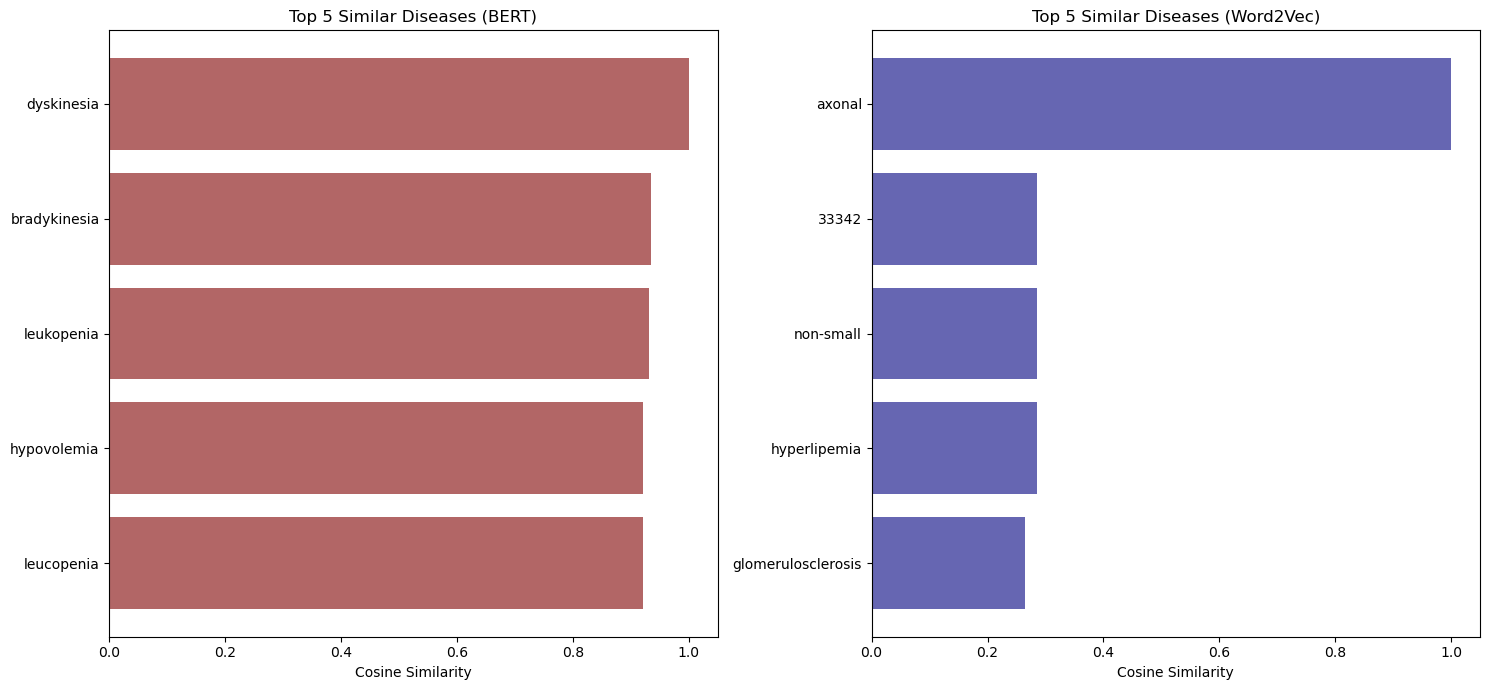

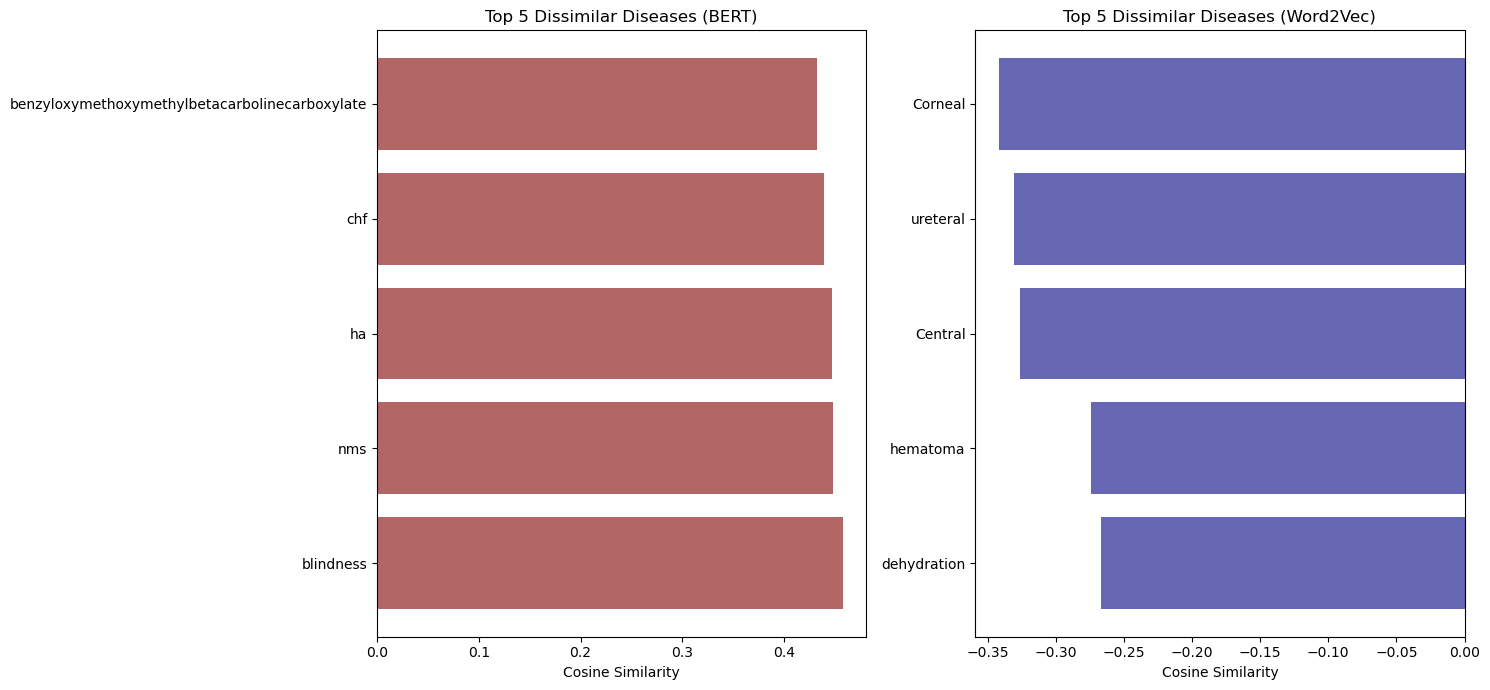

In [6]:
import matplotlib.pyplot as plt

bert_similar = [('dyskinesia', 1.0000001), ('bradykinesia', 0.9356641), ('leukopenia', 0.9325087), ('hypovolemia', 0.92168236), ('leucopenia', 0.9205851)]
bert_dissimilar = [('benzyloxymethoxymethylbetacarbolinecarboxylate', 0.43183917), ('chf', 0.4389758), ('ha', 0.44733372), ('nms', 0.448229), ('blindness', 0.45778376)]
word2vec_similar = [('axonal', 1.0), ('33342', 0.28618854), ('non-small', 0.28618854), ('hyperlipemia', 0.28457052), ('glomerulosclerosis', 0.26542783)]
word2vec_dissimilar = [('Corneal', -0.34195846), ('ureteral', -0.3303801), ('Central', -0.32598034), ('hematoma', -0.27448496), ('dehydration', -0.26664025)]
bert_similar_diseases, bert_similar_scores = zip(*bert_similar)
bert_dissimilar_diseases, bert_dissimilar_scores = zip(*bert_dissimilar)
word2vec_similar_diseases, word2vec_similar_scores = zip(*word2vec_similar)
word2vec_dissimilar_diseases, word2vec_dissimilar_scores = zip(*word2vec_dissimilar)


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].barh(bert_similar_diseases, bert_similar_scores, color='maroon', alpha=0.6, label='BERT')
ax[0].set_title('Top 5 Similar Diseases (BERT)')
ax[0].set_xlabel('Cosine Similarity')
ax[0].invert_yaxis()
ax[1].barh(word2vec_similar_diseases, word2vec_similar_scores, color='navy', alpha=0.6, label='Word2Vec')
ax[1].set_title('Top 5 Similar Diseases (Word2Vec)')
ax[1].set_xlabel('Cosine Similarity')
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].barh(bert_dissimilar_diseases, bert_dissimilar_scores, color='maroon', alpha=0.6, label='BERT')
ax[0].set_title('Top 5 Dissimilar Diseases (BERT)')
ax[0].set_xlabel('Cosine Similarity')
ax[0].invert_yaxis()
ax[1].barh(word2vec_dissimilar_diseases, word2vec_dissimilar_scores, color='navy', alpha=0.6, label='Word2Vec')
ax[1].set_title('Top 5 Dissimilar Diseases (Word2Vec)')
ax[1].set_xlabel('Cosine Similarity')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()